In [74]:
using Distributions, Plots
gr()
import SignalUtils, TxModels, Printf

# Identifiability
Given our model for transcription incorporating extrinsic noise, it is important to assess the extent to which this model can be identified from experimental data.

The message of the paper wants to be that extrinsic noise is likely to be  both significant and widely prevalent. Extrinsic noise is a necessary condition for heavy tailedness, therefore if heavy tailedness can be demonstrated then a strong argument can be made.

It is likely that given limited data samples, heavy tailedness cannot be ascertained. This then moves on to a model selection problem, for which there are several different approaches that might be employed.

## Model Selection
Whether or not the heavy tailedness can be determined, an additional approach will be model selection to determine whether extrinsic noise is significant.

### Anderson-Darling test
Statistical test to distinguish between distributions.

### AIC / BIC model selection
Standard model selection methods using the log-likelihood and the number of parameters. If parameter priors are flat and the distribution is of identical shape, this will select for the case without extrinsic noise.

Implementing integer version of genpdf.


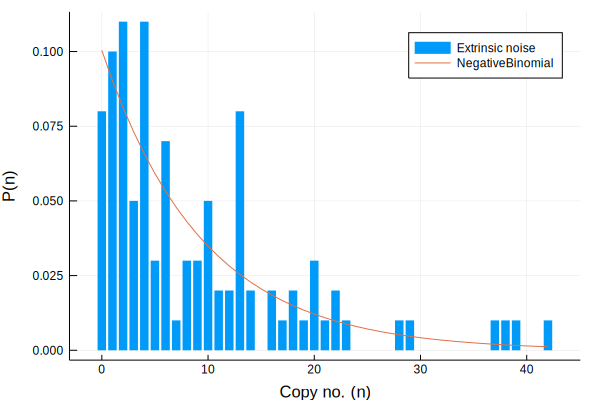

In [125]:
# Simulate some data
Params = [500, 1.0, 50.0]
σ = 0.5
# data = TxModels.samplecompound(Params,[σ*Params[1]],:NegativeBinomial,:LogNormal)
data = TxModels.simcompound(Params,[σ*Params[1]],:LogNormal, [1],100)
x,y = TxModels.genpdf(Integer.(data))
r = Params[2]
p = Params[3]/(Params[1]+Params[3])
dNB = NegativeBinomial(r,p)

bar(x,y, line=0, label="Extrinsic noise")
plot!(x, x->pdf(dNB,x), label="NegativeBinomial", xlabel="Copy no. (n)",ylabel="P(n)")

#### Optimization approach
Attempt to infer the parameters by maximising the log likelihood function. The maximum likelihood estimates may then be compared interms of the AIC and BIC criteria.

The extrinsic noise is also a nested version of the standard model: the latter is a special case of the former with the noise parameter set to zero. We may therefore also perform a $\chi^2$ test to determine if the improvement is statistically significant. 

In [93]:
# Maximum likelihood compound model
lFuncCmpnd = p -> TxModels.log_likelihood_compound(p[1:3],[p[4]],:LogNormal,[1],data; cdfMax=0.999)
optCmpnd = TxModels.maximumlikelihood([Params..., σ*Params[1]], lFuncCmpnd, false)
println(Printf.@sprintf("Compound model: AIC = %.2f",-2*lFunc(optCmpnd)+2*4))
println(Printf.@sprintf("Compound model: BIC = %.2f",-2*lFunc(optCmpnd)+log(1000)*4))

# Maximum likelihood telegraph model
lFunc = p -> TxModels.log_likelihood(p,data)
optBrsty = TxModels.maximumlikelihood(Params, lFunc, false)
println(Printf.@sprintf("Standard model: AIC = %.2f",-2*lFunc(optBrsty)+2*3))
println(Printf.@sprintf("Standard model: BIC = %.2f",-2*lFunc(optBrsty)+log(1000)*3))

# Plot results
bar(x,y, line=0, label="Simulated data")
P = TxModels.solvemaster(optBrsty, Integer(round(maximum(data)))+1)
plot!(0:1:length(P)-1, P, label="MLE (no noise)")
P = TxModels.solvecompound(optCmpnd[1:3], [optCmpnd[4]], :LogNormal, N=Integer(round(maximum(data)))+1)
plot!(0:1:length(P)-1, P, label="MLE (with noise)")

AIC value of 6691.40
BIC value of 6711.03


#### MCMC approach
Now infer parameters via a Bayesian approach by sampling from the posterior distribution. If we use flat priors for the parameters then this is equivalent to sampling from the likelihood function and has the benefit of giving a measure of the parameter sensitivity.

Completed iteration 10000 out of 500000. 
Completed iteration 20000 out of 500000. 
Completed iteration 30000 out of 500000. 
Completed iteration 40000 out of 500000. 
Completed iteration 50000 out of 500000. 
Completed iteration 60000 out of 500000. 
Completed iteration 70000 out of 500000. 
Completed iteration 80000 out of 500000. 
Completed iteration 90000 out of 500000. 
Completed iteration 100000 out of 500000. 
Completed iteration 110000 out of 500000. 
Completed iteration 120000 out of 500000. 
Completed iteration 130000 out of 500000. 
Completed iteration 140000 out of 500000. 
Completed iteration 150000 out of 500000. 
Completed iteration 160000 out of 500000. 
Completed iteration 170000 out of 500000. 
Completed iteration 180000 out of 500000. 
Completed iteration 190000 out of 500000. 
Completed iteration 200000 out of 500000. 
Completed iteration 210000 out of 500000. 
Completed iteration 220000 out of 500000. 
Completed iteration 230000 out of 500000. 
Completed iteration 

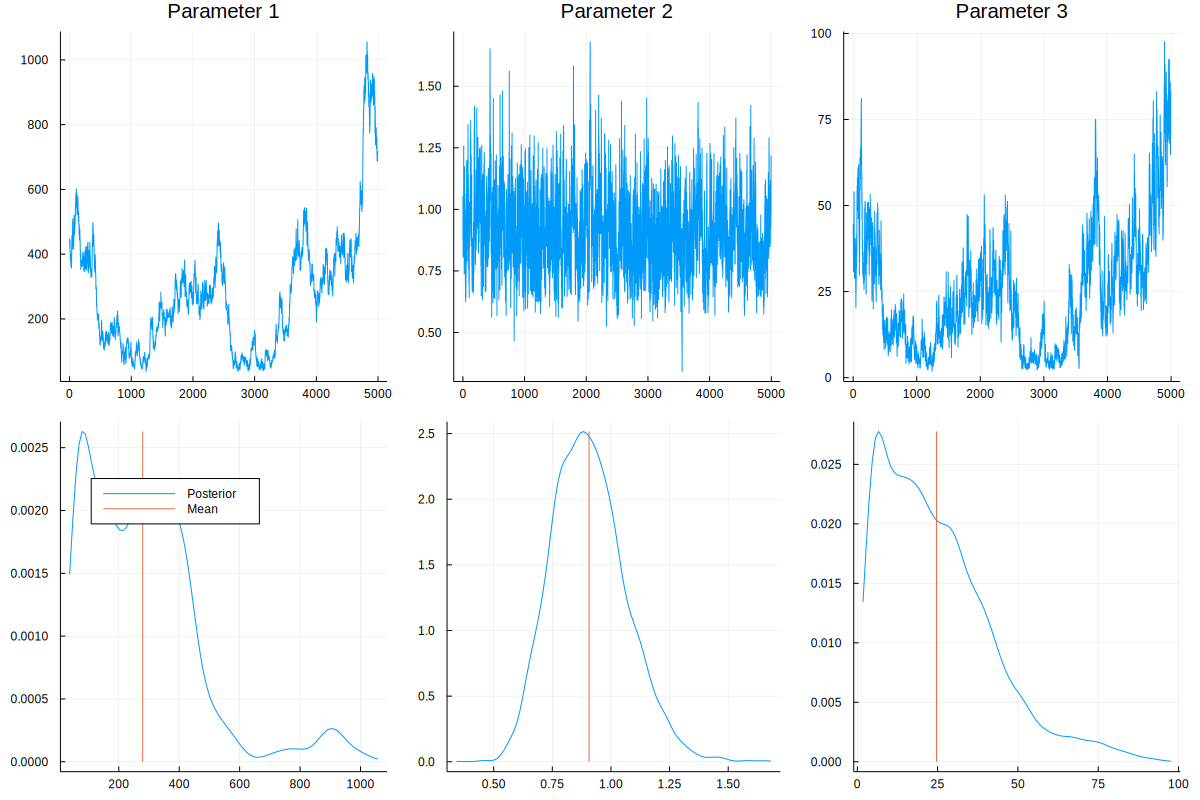

In [132]:
chain = TxModels.mcmc_metropolis(Params,lFunc,500000, propVar=0.08,burn=500,step=100)
plt = TxModels.plot_chain(chain)
plot(plt)

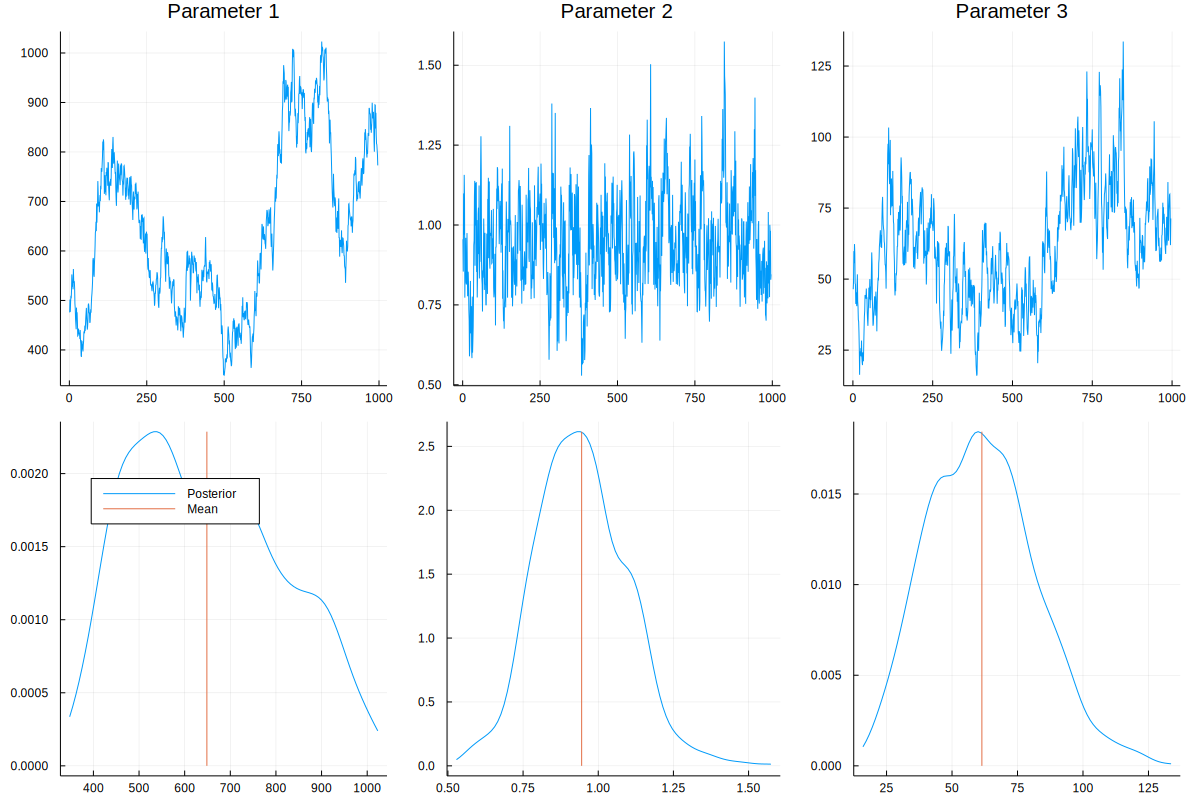

In [128]:
plt = TxModels.plot_chain(chain)
plot(plt)

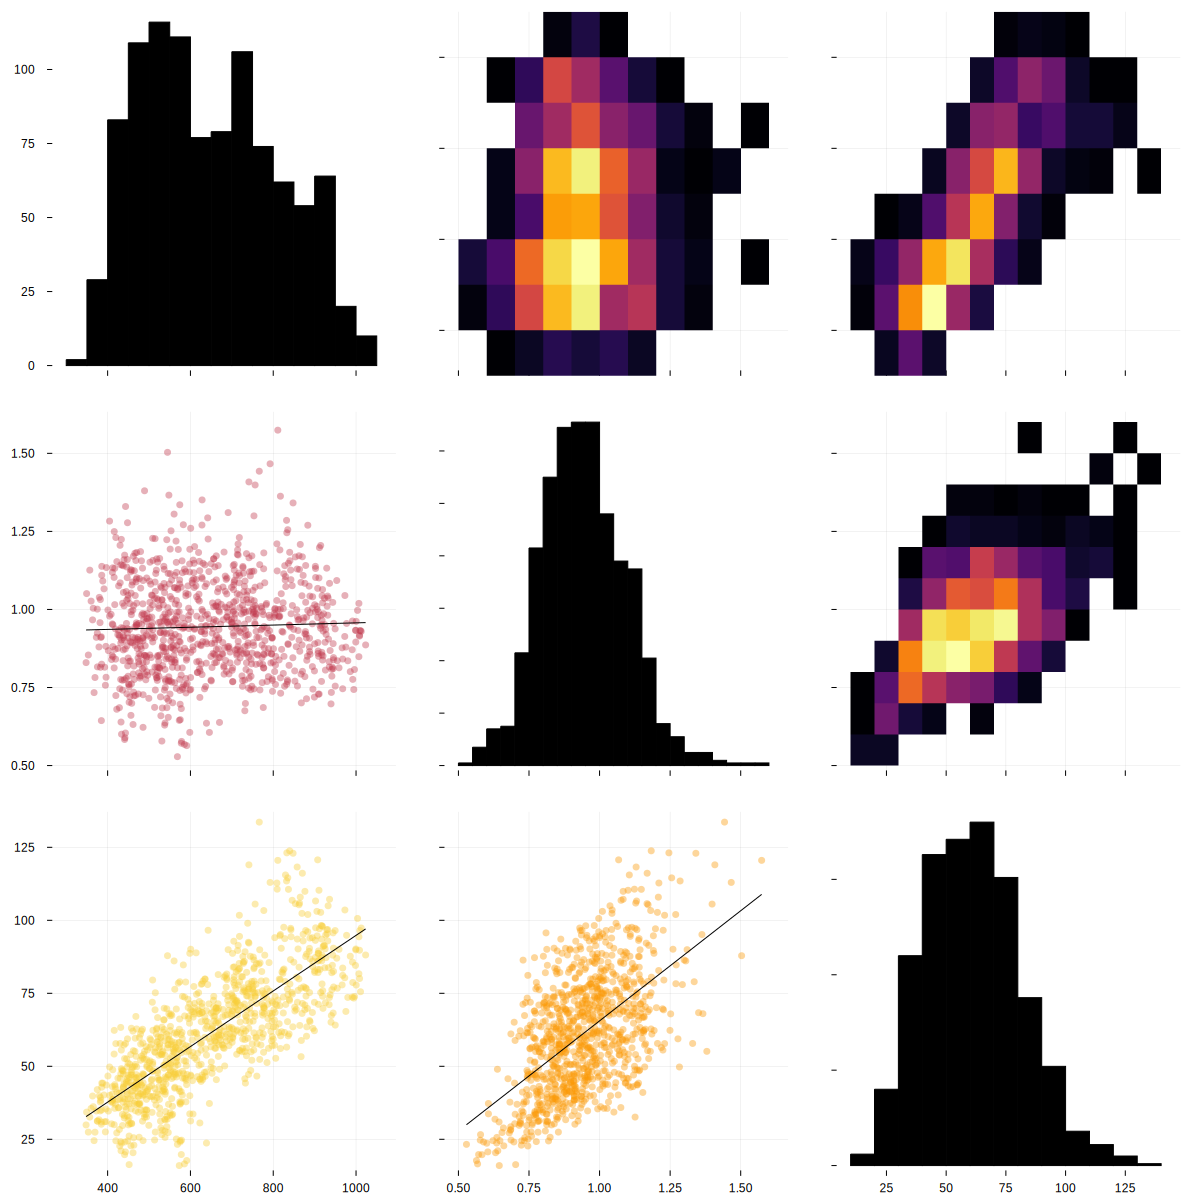

In [130]:
TxModels.corrplot(chain)